## ASSIGNMENT 

1. Use pytorch to model class face recognition using master_dataset.npz

In [43]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from sklearn.model_selection import train_test_split
import random



In [44]:
# Load the data 

dataSet = '../mahPrj/master_dataset.npz'
with np.load(dataSet, allow_pickle=True) as data:
    dataImages = data['images']
    dataLabels = data['labels']
    dataLabelNames = data['labelnames']

In [45]:
# Convert size 

import cv2 as cv 


N = len(dataImages)
shape = (N, 200, 200, 3)
y = np.empty(shape)

for i in range(N):
    y[i] = cv.resize(dataImages[i], [200,200], interpolation=cv.INTER_NEAREST)

dataImages.dtype, y.dtype, y.shape

dataImages = y

In [46]:
# Normalize

dataImages = dataImages / 255.0

In [47]:
print(dataLabels.dtype)
dataLabels = dataLabels.astype('int64')

print(dataLabels.dtype)

int32
int64


In [48]:
# Transform into torch

dataImages2 = torch.Tensor(dataImages)

In [49]:
# Convert to tuple

all_data = []
for i in range(len(dataImages2)):
   all_data.append([dataImages2[i], dataLabels[i]])

random.shuffle(all_data)



In [50]:
# Split data into training and testing - based on tuple

train_size = int(0.75 * len(all_data))
test_size = len(all_data) - train_size
train_dataset, test_dataset, = torch.utils.data.random_split(all_data, [train_size, test_size])

In [51]:
# Check the size of train_dataset and test_dataset

len(train_dataset), len(test_dataset)

(317, 106)

In [52]:
classes = {
    0: "afiq",
    1: "azureen",
    2: "gavin",
    3: "goke",
    4: "inamul",
    5: "jincheng",
    6: "mahmuda",
    7: "numan",
    8: "saseendran"
}

In [53]:
X, y = train_dataset[0]
print(X.shape)
print(X.squeeze().shape)
print(y)

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
2


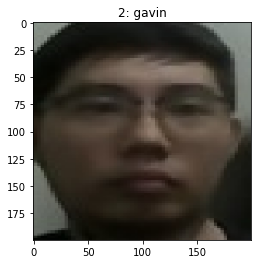

In [54]:
# Display
img = X.squeeze()
plt.imshow(img, cmap="gray")
plt.title(f"{y}: {classes[y]}")
plt.show()

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
6


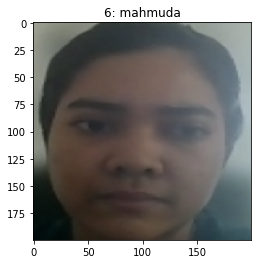

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
1


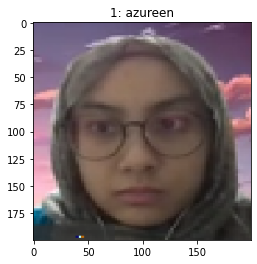

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
3


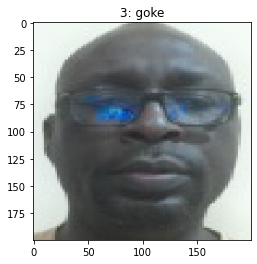

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
6


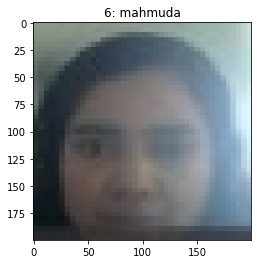

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
6


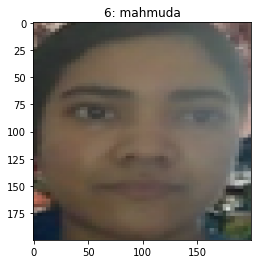

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
2


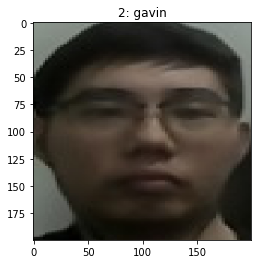

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
3


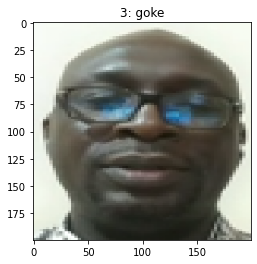

torch.Size([200, 200, 3])
torch.Size([200, 200, 3])
3


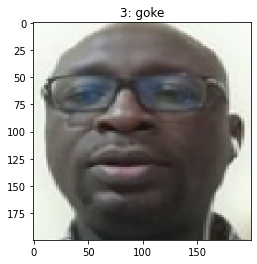

In [55]:
# Display in loop 

for i in range (2,10):

    X, y = train_dataset[i]
    print(X.shape)
    print(X.squeeze().shape)
    print(y)

    img = X.squeeze()
    plt.imshow(img, cmap="gray")
    plt.title(f"{y}: {classes[y]}")
    plt.show()

In [56]:
batch_size = 20

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([20, 200, 200, 3])
Shape of y:  torch.Size([20]) torch.int64


In [57]:
import torch

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

input_features = 3*200*200
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 9)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=9, bias=True)
  )
)


In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [79]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            
        return loss,current

In [80]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss,correct

In [81]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 2
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 3
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 4
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 5
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 6
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 7
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 8
-------------------------------
loss: 1.378945  [    0/  317]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.402917 

Epoch 9
----------------

In [62]:
torch.save(model.state_dict(), "model_2.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [63]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_2.pth"))

<All keys matched successfully>

In [64]:
model.eval()
x, y = test_dataset[0][0], test_dataset[0][1]
x = x.view(1, -1)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "goke", Actual: "goke"


In [65]:
pred[0]

tensor([ 0.2905,  0.1555, -0.0032,  2.2359, -2.5919, -1.6939,  0.0406,  0.0665,
        -0.2172])

In [71]:
model.eval()
x, y = test_dataset[77][0], test_dataset[77][1]
x = x.view(1, -1)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "numan", Actual: "numan"


In [67]:
pred[0]

tensor([ 0.2550,  0.1093, -0.6343, -1.0348,  0.4887, -0.0440, -0.2364,  0.5999,
         0.1662])

In [78]:
i = 40
model.eval()
x, y = test_dataset[i][0], test_dataset[i][1]
x = x.view(1, -1)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0).item()], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "saseendran", Actual: "mahmuda"
